In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score # Added metrics imports


In [42]:
# Load and preprocess data
file_path = "/kaggle/input/air-traffic-landings/air-traffic-landings-statistics.csv"
df = pd.read_csv(file_path)
df['Activity Period'] = pd.to_datetime(df['Activity Period'], format='%Y%m')
df = df.sort_values(by='Activity Period')

In [43]:

# Aggregate monthly landing counts
df_grouped = df.groupby('Activity Period').sum().reset_index()

In [44]:

# Create complete time series with all months
date_range = pd.date_range(start=df_grouped['Activity Period'].min(), 
                           end=df_grouped['Activity Period'].max(), 
                           freq='MS')
landing_counts = df_grouped.set_index('Activity Period').reindex(date_range, fill_value=0).reset_index().rename(columns={'index': 'Activity Period'})

# Feature engineering: Add cyclical month encoding
landing_counts['Month'] = landing_counts['Activity Period'].dt.month
landing_counts['Month_sin'] = np.sin(2 * np.pi * landing_counts['Month']/12)
landing_counts['Month_cos'] = np.cos(2 * np.pi * landing_counts['Month']/12)

In [45]:
# Scale features
features = ['Landing Count', 'Month_sin', 'Month_cos']
scaler = MinMaxScaler()
landing_counts[features] = scaler.fit_transform(landing_counts[features])

In [46]:
# Create sequences with multiple features
SEQ_LENGTH = 12  # Increased sequence length to capture 2-year patterns

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Target is Landing Count
    return np.array(X), np.array(y)

data_values = landing_counts[features].values
X, y = create_sequences(data_values, SEQ_LENGTH)

In [47]:
# Split into train (80%) and test (20%)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [48]:
# Model architecture with regularization
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(SEQ_LENGTH, len(features)),
         kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    LSTM(128, return_sequences=True, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    LSTM(64, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
# Compile with learning rate schedule
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# Enhanced early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, 
                    epochs=500, 
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop], 
                    verbose=1)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 792ms/step - loss: 0.7184 - val_loss: 0.8993
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.6358 - val_loss: 0.7276
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.5545 - val_loss: 0.5646
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.5114 - val_loss: 0.4969
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.5171 - val_loss: 0.4871
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.4965 - val_loss: 0.5037
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.4750 - val_loss: 0.5334
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.4670 - val_loss: 0.5479
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.4583 - val_loss: 0.5352
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.4478 - val_loss: 0.5044
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.4290 - val_loss: 0.4669
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.41

In [50]:

# Prepare for inverse scaling
test_indices = range(split + SEQ_LENGTH, split + SEQ_LENGTH + len(y_test))
test_features = data_values[test_indices, 1:]

# Generate predictions
y_pred = model.predict(X_test)

# Inverse scale predictions and actual values
y_pred_scaled = np.concatenate([y_pred, test_features], axis=1)
y_pred_inv = scaler.inverse_transform(y_pred_scaled)[:, 0]

y_test_scaled = np.concatenate([y_test.reshape(-1,1), test_features], axis=1)
y_test_inv = scaler.inverse_transform(y_test_scaled)[:, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [51]:

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Improved Root Mean Squared Error (RMSE): {rmse}")

Improved Root Mean Squared Error (RMSE): 916.3841380769195


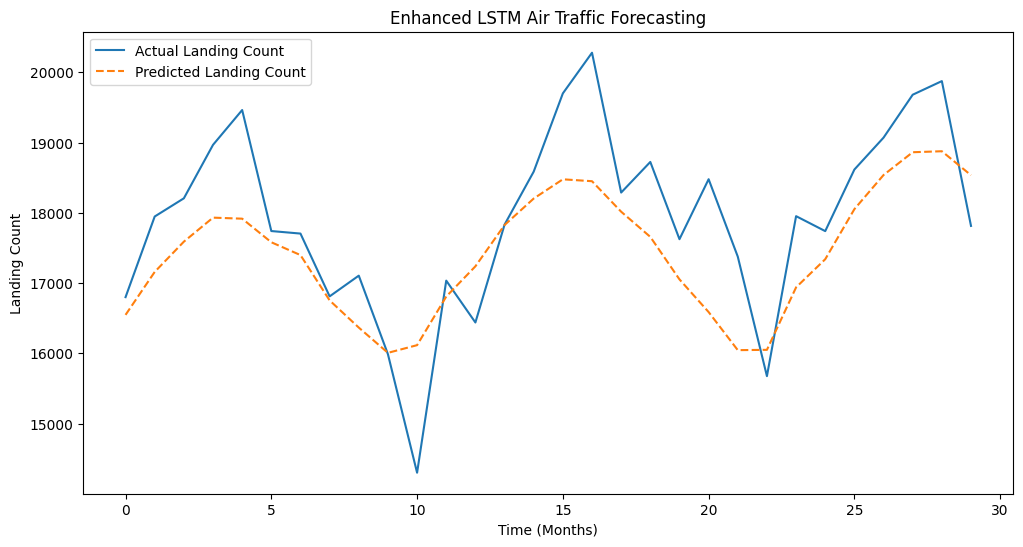

In [52]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Landing Count")
plt.plot(y_pred_inv, label="Predicted Landing Count", linestyle="dashed")
plt.xlabel("Time (Months)")
plt.ylabel("Landing Count")
plt.legend()
plt.title("Enhanced LSTM Air Traffic Forecasting")
plt.show()

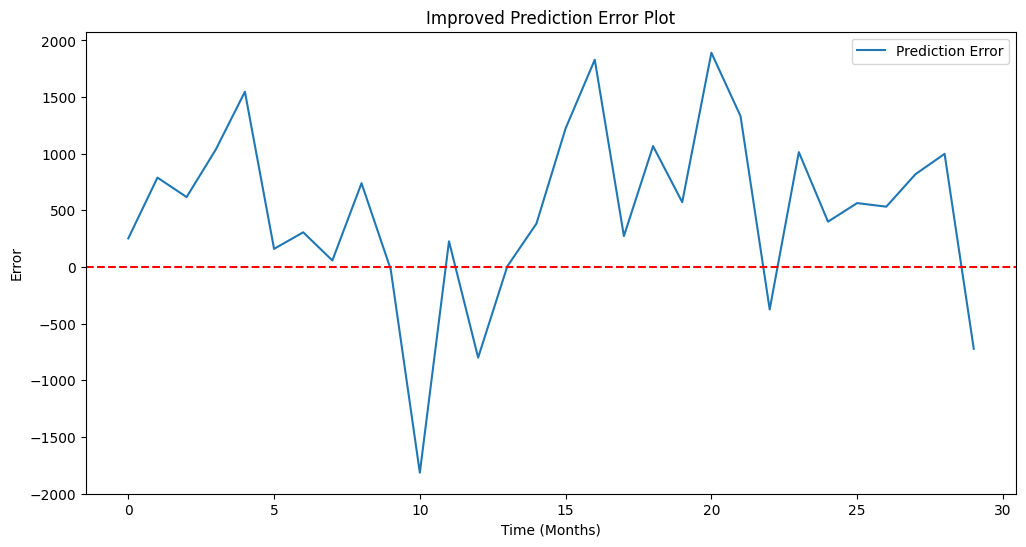

In [53]:
# Error plot
error = y_test_inv - y_pred_inv
plt.figure(figsize=(12, 6))
plt.plot(error, label="Prediction Error")
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("Time (Months)")
plt.ylabel("Error")
plt.legend()
plt.title("Improved Prediction Error Plot")
plt.show()

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a threshold, for instance, using the median of actual landing counts
threshold = np.median(y_test_inv)  # You can also use y_test_inv.mean() if preferred

# Convert the continuous values to binary classes based on the threshold
y_test_binary = (y_test_inv >= threshold).astype(int)
y_pred_binary = (y_pred_inv >= threshold).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.80
Precision: 0.91
Recall: 0.67
F1 Score: 0.77


In [55]:
from sklearn.metrics import mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

RMSE: 916.38
MAE: 745.58
R^2 Score: 0.51


Linear Regression - RMSE: 0.05922978890595051, MAE: 0.048637162778417835
Random Forest - RMSE: 0.13534099807774916, MAE: 0.11730700631507078
XGBoost - RMSE: 0.16576233685689543, MAE: 0.14325447959549134


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
GRU - RMSE: 0.14603509830592368, MAE: 0.11986672807256608
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
LSTM - RMSE: 1.0111721124747532, MAE: 1.0067461466622405

Model Comparison:
               Model      RMSE       MAE
0  Linear Regression  0.059230  0.048637
1      Random Forest  0.135341  0.117307
2            XGBoost  0.165762  0.143254
3                GRU  0.146035  0.119867
4               LSTM  1.011172  1.006746


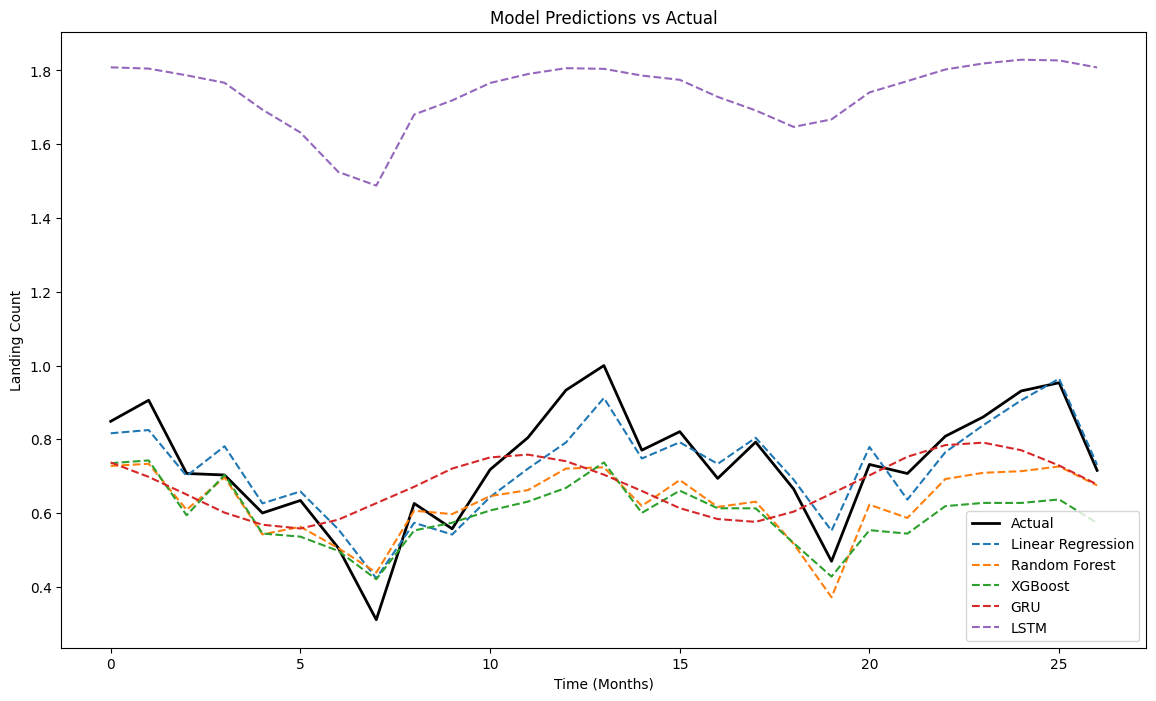

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Prepare data (same as before)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Target is Landing Count
    return np.array(X), np.array(y)

SEQ_LENGTH = 24
data_values = landing_counts[features].values
X, y = create_sequences(data_values, SEQ_LENGTH)

# Split dataset
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Flatten X for non-RNN models (Linear Regression, Random Forest, XGBoost)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - RMSE: {rmse}, MAE: {mae}")
    return y_pred, rmse, mae

# 1. Linear Regression
lr_model = LinearRegression()
lr_pred, lr_rmse, lr_mae = evaluate_model(lr_model, X_train_flat, X_test_flat, y_train, y_test, "Linear Regression")

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pred, rf_rmse, rf_mae = evaluate_model(rf_model, X_train_flat, X_test_flat, y_train, y_test, "Random Forest")

# 3. XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_pred, xgb_rmse, xgb_mae = evaluate_model(xgb_model, X_train_flat, X_test_flat, y_train, y_test, "XGBoost")

# 4. GRU Model
def build_gru_model(input_shape):
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

gru_model = build_gru_model((X_train.shape[1], X_train.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
gru_model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
gru_pred = gru_model.predict(X_test)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_pred))
gru_mae = mean_absolute_error(y_test, gru_pred)
print(f"GRU - RMSE: {gru_rmse}, MAE: {gru_mae}")

# 5. LSTM Model (your existing model)
lstm_pred = model.predict(X_test)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print(f"LSTM - RMSE: {lstm_rmse}, MAE: {lstm_mae}")

# Compare Results
results = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost", "GRU", "LSTM"],
    "RMSE": [lr_rmse, rf_rmse, xgb_rmse, gru_rmse, lstm_rmse],
    "MAE": [lr_mae, rf_mae, xgb_mae, gru_mae, lstm_mae]
}

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Plot predictions vs. actual values
plt.figure(figsize=(14, 8))
plt.plot(y_test, label="Actual", color='black', linewidth=2)
plt.plot(lr_pred, label="Linear Regression", linestyle='dashed')
plt.plot(rf_pred, label="Random Forest", linestyle='dashed')
plt.plot(xgb_pred, label="XGBoost", linestyle='dashed')
plt.plot(gru_pred, label="GRU", linestyle='dashed')
plt.plot(lstm_pred, label="LSTM", linestyle='dashed')
plt.xlabel("Time (Months)")
plt.ylabel("Landing Count")
plt.title("Model Predictions vs Actual")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


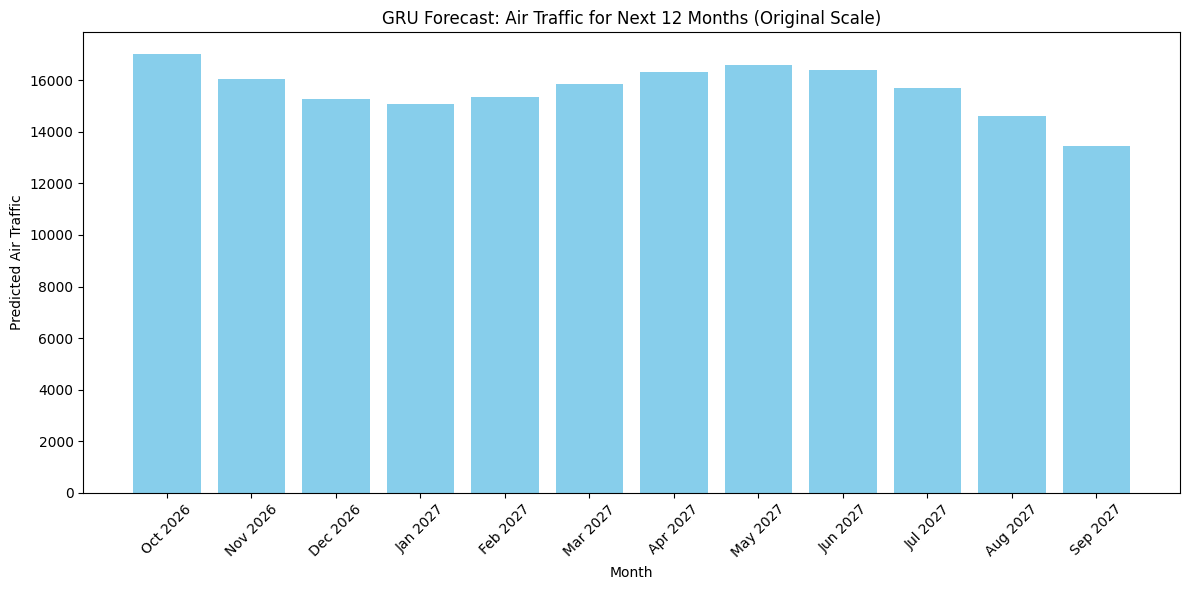


Forecasted Air traffic for the Next 12 Months:
       Month  Predicted Landing Count
0   Oct 2026             17016.934228
1   Nov 2026             16066.707122
2   Dec 2026             15282.744086
3   Jan 2027             15099.503351
4   Feb 2027             15362.550994
5   Mar 2027             15842.888674
6   Apr 2027             16345.785422
7   May 2027             16614.082284
8   Jun 2027             16424.225185
9   Jul 2027             15706.970584
10  Aug 2027             14615.218669
11  Sep 2027             13443.353046


In [58]:

month_sin_idx = 1
month_cos_idx = 2

current_sequence_scaled = data_values[-SEQ_LENGTH:].copy()

# Extract the last date from the dataset correctly
last_date = landing_counts['Activity Period'].iloc[-1]
current_year = 2026
current_month = last_date.month

# Initialize lists to store future predictions and dates
future_predictions_scaled = [] # Store scaled predictions
future_predictions_original_scale = [] # Store inverse scaled predictions
future_dates = []

# Generate future predictions for 12 months
for _ in range(12):
    # Predict next month's landing count using the *scaled* current sequence
    pred_scaled = gru_model.predict(current_sequence_scaled.reshape(1, SEQ_LENGTH, -1))[0, 0]
    future_predictions_scaled.append(pred_scaled)

    # Inverse scale the prediction to get the actual landing count
    pred_for_inverse_scaling = np.array([[pred_scaled, 0, 0]]) # Dummy month features for inverse transform
    pred_original_scale = scaler.inverse_transform(pred_for_inverse_scaling)[:, 0][0] # Inverse transform and take Landing Count
    future_predictions_original_scale.append(pred_original_scale)

    # Update month and year for the next iteration
    current_month += 1
    if current_month > 12:
        current_month = 1
        current_year += 1

    # Create new row for the next prediction input
    new_row_scaled = current_sequence_scaled[-1].copy() # Copy last row of scaled sequence
    new_row_scaled[0] = pred_scaled # Update with the *scaled* prediction

    # Calculate new month features for the updated month
    new_month_sin = np.sin(2 * np.pi * current_month / 12)
    new_month_cos = np.cos(2 * np.pi * current_month / 12)
    new_row_scaled[month_sin_idx] = new_month_sin # Update Month_sin
    new_row_scaled[month_cos_idx] = new_month_cos # Update Month_cos

    # Update current sequence by dropping the oldest month and adding the new row
    current_sequence_scaled = np.vstack([current_sequence_scaled[1:], new_row_scaled])

    # Store future date for plotting
    future_dates.append(f"{current_month:02d}/{current_year}")

# Convert future_dates to datetime for plotting
future_dates = pd.to_datetime(future_dates, format='%m/%Y')

# Plotting the predictions in original scale
plt.figure(figsize=(12, 6))
plt.bar(future_dates.strftime('%b %Y'), future_predictions_original_scale, color='skyblue')
plt.xlabel("Month")
plt.ylabel("Predicted Air Traffic")
plt.title("GRU Forecast: Air Traffic for Next 12 Months (Original Scale)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the predicted values along with the dates
forecast_df = pd.DataFrame({'Month': future_dates.strftime('%b %Y'), 'Predicted Landing Count': future_predictions_original_scale})
print("\nForecasted Air traffic for the Next 12 Months:")
print(forecast_df)